# CatBoost : SkLearn API

Read Titanic Data

Split Data : Train, Validation, Test

Convert Data to CatBoost Data Structure

Build Model using CatBoost API

Model using Default Parameters

Predict

Performance Measure on Test Data

Plot Metrics

SHAP Analysis

Cross Validation

Probability Calibration 

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn import metrics 

In [3]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric, get_confusion_matrix, get_roc_curve, get_fnr_curve, get_fpr_curve

### Read Data

In [4]:
# import seaborn as sns
# train_df = sns.load_dataset('titanic')
# train_df = train_df.drop(['who','alive','alone'], axis=1)

In [5]:
# """CatBoost"""
#from catboost.datasets import titanic
#train_df, test_df = titanic()

In [6]:
# null_value_stats = train_df.isnull().sum(axis=0)
# null_value_stats[null_value_stats != 0]
# train_df.fillna(-9999, inplace=True)
# test_df.fillna(-9999, inplace=True)

In [7]:
# X = train_df.drop('Survived', axis=1)
# y = train_df.Survived

In [8]:
from ipynb.fs.full.dataProcessing_titanicData import *

In [9]:
train_df, test_df = train_test_ordinal

In [10]:
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

#### Split Data

In [11]:
"""Setting the Seed"""
theSeed = 209

In [12]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.80, random_state=theSeed)
print(f'train data: {X_train.shape}')
print(f'valid data: {X_valid.shape}')

train data: (785, 14)
valid data: (197, 14)


In [14]:
#X_test = test_df
X_test = test_df.drop(['Survived'], axis=1)
y_test = test_df.Survived
print(f'test data : {X_test.shape}')

test data : (327, 14)


#### Setting Weight to the Data

In [15]:
# class_weights = [1.85, 2.17]
# scale_pos_weight = np.random.rand(X_train.shape[0], )
# weight = np.random.rand(X_train.shape[0], )

#### CatBoost Data Structure 

In [16]:
# train_data = Pool(X_train, label=y_train, cat_features=categorical_features_indices, weight=None)
# valid_data = Pool(X_valid, label=y_valid, cat_features=categorical_features_indices, weight=None)
# test_data  = Pool(X_test, label=y_test, cat_features=categorical_features_indices, weight=None)

In [17]:
train_data = Pool(X_train, label=y_train, weight=None)
valid_data = Pool(X_valid, label=y_valid, weight=None)
test_data  = Pool(X_test, label=y_test, weight=None)

### Train Model

#### Model with Default Parameters

In [18]:
model = CatBoostClassifier(
    loss_function='Logloss',
    custom_loss=['Accuracy','Logloss','F1'],
    eval_metric='AUC', 
    iterations=100,
    learning_rate=0.03, 
    l2_leaf_reg=3.0, 
    logging_level='Silent',
    early_stopping_rounds=None,
    model_shrink_mode=None,
    use_best_model=False,
    random_seed=theSeed
)

In [19]:
fit = model.fit(
    X_train, y_train,
    #cat_features=categorical_features_indices,
    eval_set=[(X_valid, y_valid)],
    plot=False
)

#### Model Evaluation

In [20]:
from catboost import utils

In [21]:
# utils.eval_metrics(valid_data,
#              'AUC',
#              ntree_start=0,
#              ntree_end=0,
#              eval_period=1,
#              thread_count=-1)

In [22]:
train_eval      = fit.eval_metrics(train_data, ['AUC'], plot=False)
valid_eval_auc  = fit.eval_metrics(valid_data, ['AUC'], plot=False)
valid_eval_loss = fit.eval_metrics(valid_data, ['Logloss'], plot=False)
valid_eval_f1   = fit.eval_metrics(valid_data, ['F1'], plot=False)

In [23]:
tn, fp, fn, tp = utils.get_confusion_matrix(model, valid_data).ravel()
print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}")

TN:126.0, FP:2.0, FN:2.0, TP:67.0


In [24]:
thresholds, fpr = utils.get_fpr_curve(model, valid_data, plot=False)
thresholds, fnr = utils.get_fnr_curve(model, valid_data, plot=False)

In [25]:
fpr, tpr, thresholds = utils.get_roc_curve(model, valid_data, plot=False)

In [26]:
meanAUC = np.mean( np.array(valid_eval_auc['AUC']) )
stdvAUC = np.std( np.array(valid_eval_auc['AUC']) )
print(f"Mean & Std of AUC : { round(meanAUC,4),  round(stdvAUC,4)}")

Mean & Std of AUC : (0.9876, 0.0015)


In [27]:
utils.get_confusion_matrix(fit, valid_data)

array([[126.,   2.],
       [  2.,  67.]])

In [28]:
feature_importances = model.get_feature_importance(train_data)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print(f"{name}  : {round(score,2)}" )

Boat  : 86.95
Sex  : 4.24
Title  : 1.69
Embarked  : 0.97
Fare  : 0.88
Ticket  : 0.84
NameLength  : 0.68
Age  : 0.64
HomeDest  : 0.57
LastName  : 0.54
Cabin  : 0.52
SibSp  : 0.5
Parch  : 0.49
Pclass  : 0.47


In [29]:
auc = valid_eval_auc['AUC']
auc = np.array(auc)
print(f"Mean AUC  : { round(auc.mean(),4)}")
loss = valid_eval_loss['Logloss']
loss = np.array(loss)
print(f"Mean Loss : { round(loss.mean(),4)}")

Mean AUC  : 0.9876
Mean Loss : 0.2727


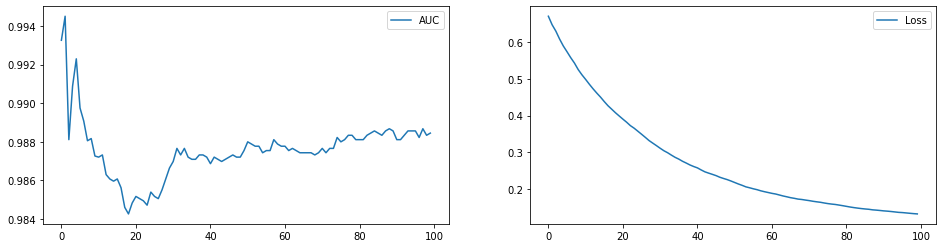

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
ax[0].plot(auc, label='AUC')
ax[1].plot(loss,label='Loss')

ax[0].legend()
ax[1].legend()
plt.show()

In [31]:
# features = 2
# model.plot_partial_dependence(train_data, features)

# model.plot_predictions(train_data, features_to_change=[1,2,3])
# model.plot_tree(tree_idx=0, pool=train_data)

### Predict

In [32]:
y_pred  = model.predict(
        X_test,
        prediction_type='Class',
        ntree_start=0, 
        ntree_end=0, 
        thread_count=-1, 
        verbose=False)

y_score  = model.predict(
        X_test,
        prediction_type='Probability',
        ntree_start=0, 
        ntree_end=0, 
        thread_count=-1, 
        verbose=False)

# Score can also be Obtained using predict_proba
#y_score = model.predict_proba(X_test)

### Performance Metrics on Test Data

In [33]:
from sklearn import metrics

In [34]:
"""Accuracy Score"""
accuracy = metrics.accuracy_score(y_test, y_pred, sample_weight=None, normalize=True)
print( round(accuracy, 4))

0.9664


In [35]:
"""Balanced Accuracy Score"""
balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred, sample_weight=None, adjusted=False)
print( round(balanced_accuracy, 4))

0.9629


In [36]:
"""ROC Curve"""
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])

In [37]:
"""AUC"""
auc = metrics.auc(fpr, tpr)
print( round(auc, 4))

0.9856


In [38]:
"""Confusion Matrix"""
metrics.confusion_matrix(y_test, y_pred)

array([[187,   3],
       [  8, 129]])

In [39]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}")

TN:187, FP:3, FN:8, TP:129


In [40]:
"""F1 Score"""
f1 = metrics.f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
print( round(f1, 4))

0.9591


In [41]:
"""Log Loss"""
metrics.log_loss(y_test, y_score[:, 1], normalize=True, sample_weight=None, labels=[0,1])

0.1543995837201022

In [42]:
"""Precision, Recall, Fscore, Support"""
metrics.precision_recall_fscore_support(y_test, y_pred, labels=[0,1], pos_label=1, 
                                        average=None, sample_weight=None)

(array([0.95897436, 0.97727273]),
 array([0.98421053, 0.94160584]),
 array([0.97142857, 0.95910781]),
 array([190, 137]))

In [43]:
precision = metrics.precision_score(y_test, y_pred, labels=[0,1], pos_label=1, 
                                    average='binary', sample_weight=None)
print( round(precision, 4))

0.9773


In [44]:
recall = metrics.recall_score(y_test, y_pred, labels=[0,1], pos_label=1, 
                              average='binary', sample_weight=None)
print( round(recall, 4))

0.9416


Basic Plots

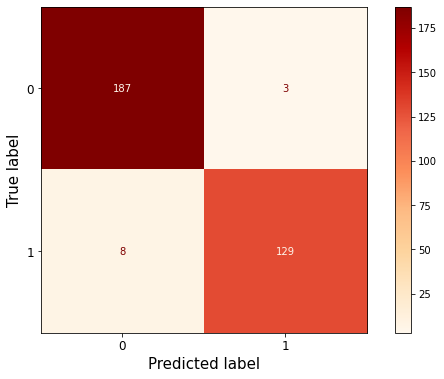

In [45]:
fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlabel("", fontsize=15)
ax.set_ylabel("", fontsize=15)
ax.set_xticklabels([0,1], fontsize=12)
ax.set_yticklabels([0,1], fontsize=12)

metrics.plot_confusion_matrix(
    model, X_test, y_test, 
    labels=None, sample_weight=None, normalize=None, 
    display_labels=[0,1], 
    cmap='OrRd', 
    #color='w',
    ax=ax)

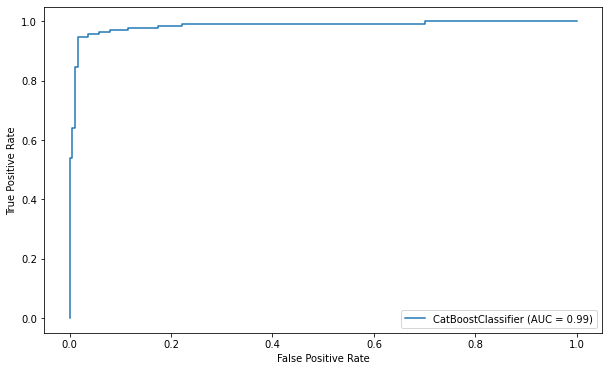

In [46]:
fig, ax = plt.subplots(figsize=(10,6))
metrics.plot_roc_curve(model, X_test, y_test, sample_weight=None, ax=ax)

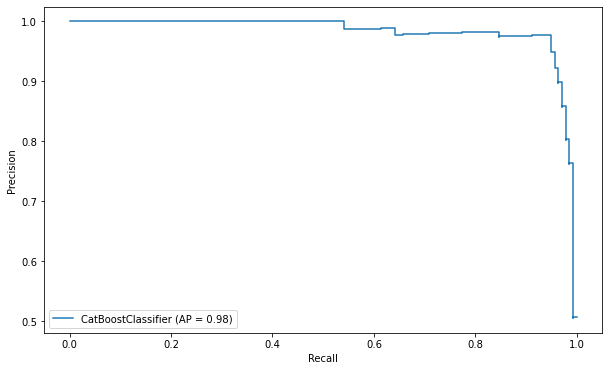

In [47]:
fig, ax = plt.subplots(figsize=(10,6))
metrics.plot_precision_recall_curve(model, X_test, y_test, sample_weight=None, ax=ax)

### SHAP Analysis

In [48]:
import shap
shap.initjs()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [49]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

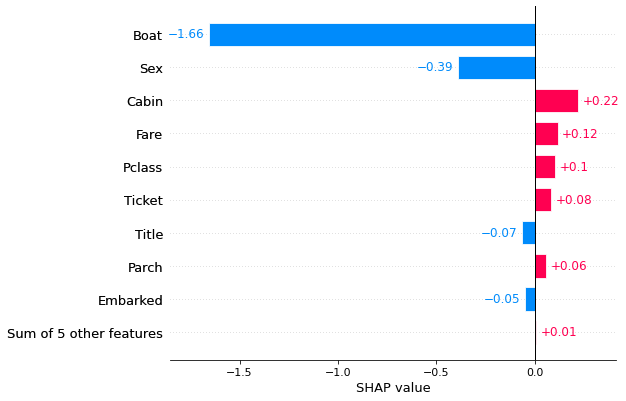

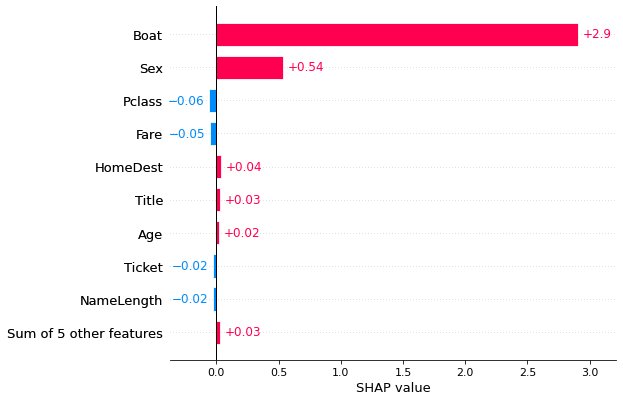

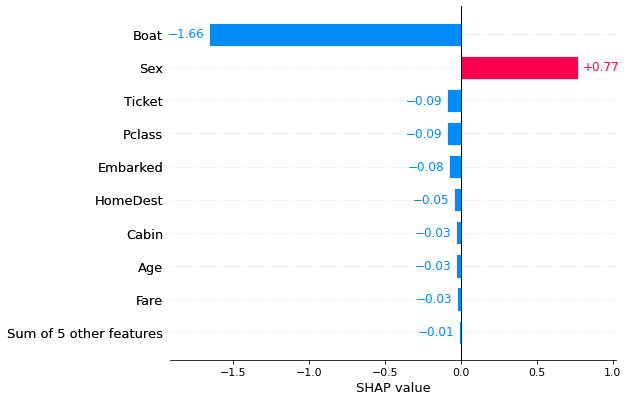

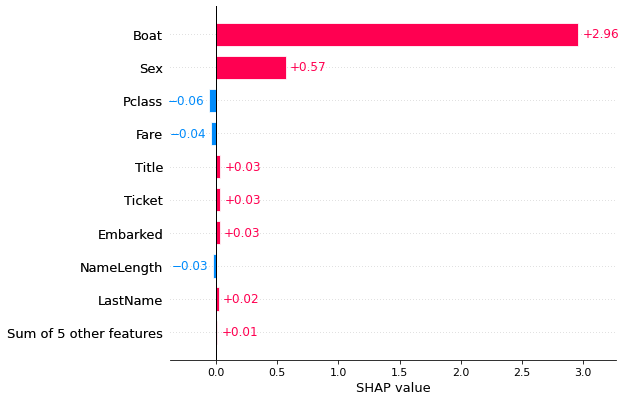

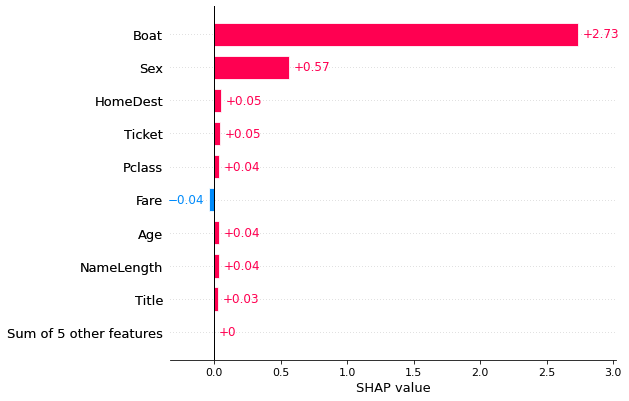

In [50]:
for i in range(5):
    shap.plots.bar(shap_values[i])

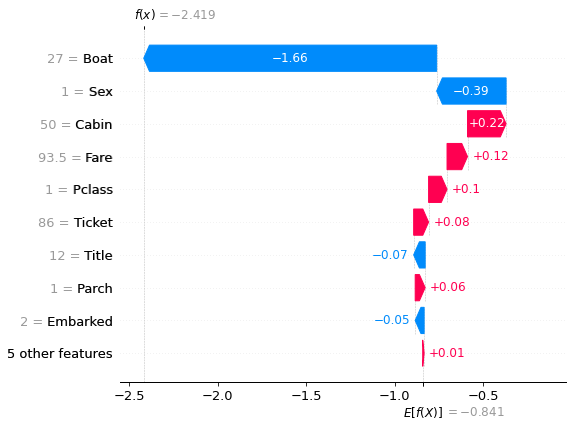

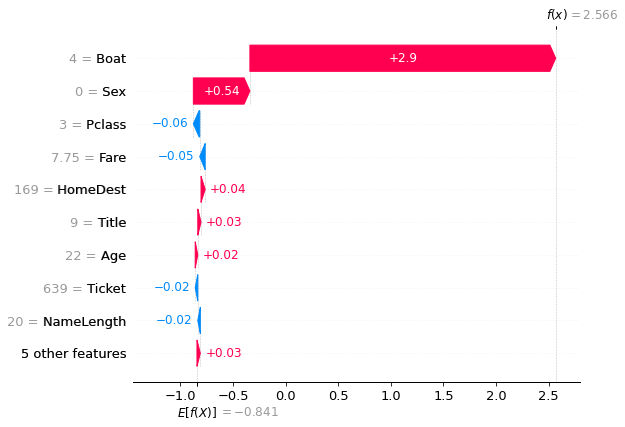

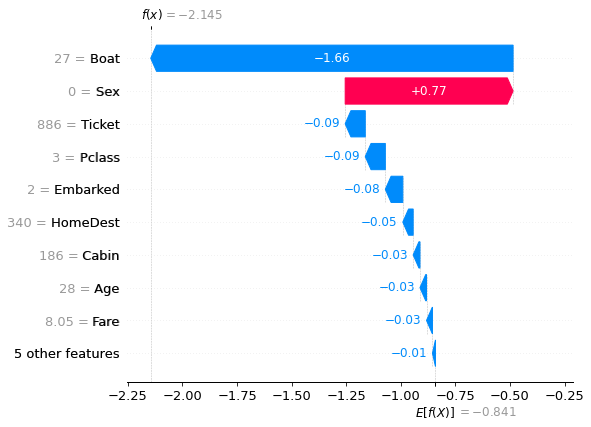

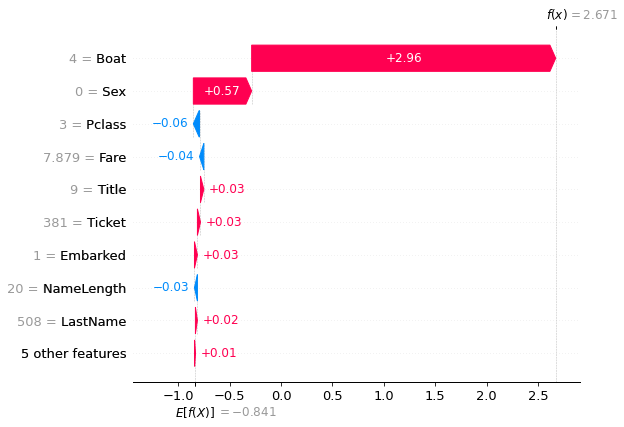

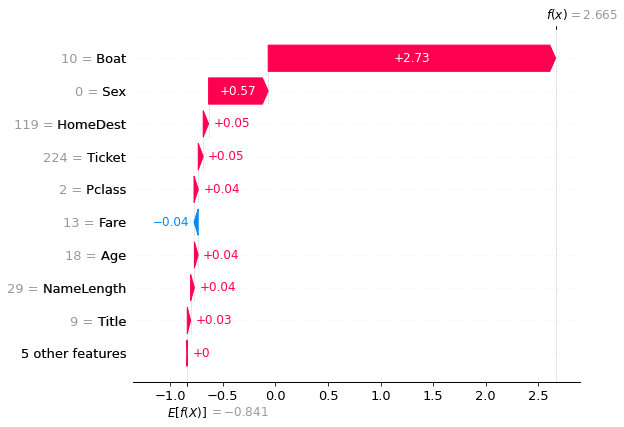

In [51]:
for i in range(5):
    shap.plots.waterfall(shap_values[i])

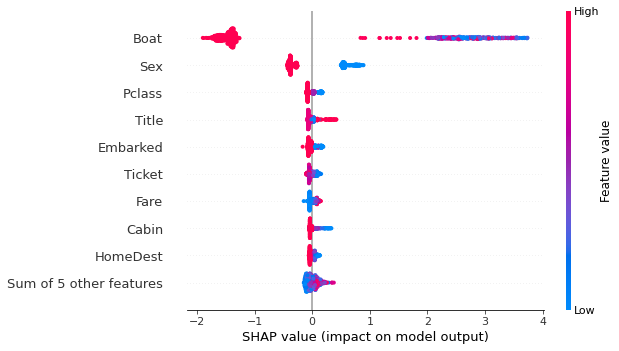

In [52]:
shap.plots.beeswarm(shap_values)

In [53]:
treeExplainer = shap.TreeExplainer(
    model, 
    data=None, 
    feature_perturbation= "tree_path_dependent", 
    model_output='raw')
shap_values = treeExplainer.shap_values(X_train)

Visualize the first prediction's explanation

In [54]:
shap.force_plot(treeExplainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Visualize the Training set Predictions

In [55]:
shap.force_plot(treeExplainer.expected_value, shap_values, X_train)

SHAP Summary Plot

Summarize the effects of all the features

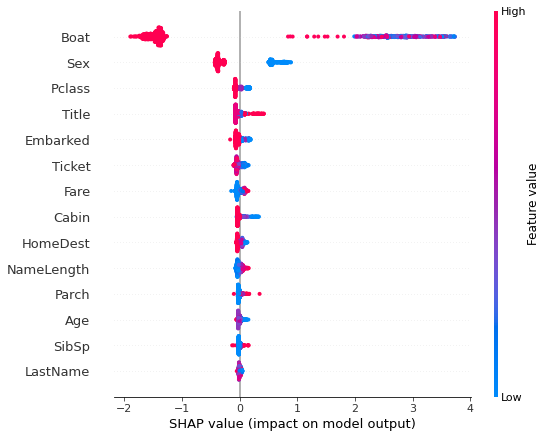

In [56]:
shap.summary_plot(shap_values, X_train)

SHAP Dependence Plot

Create a SHAP dependence plot to show the effect of a single feature across the whole dataset

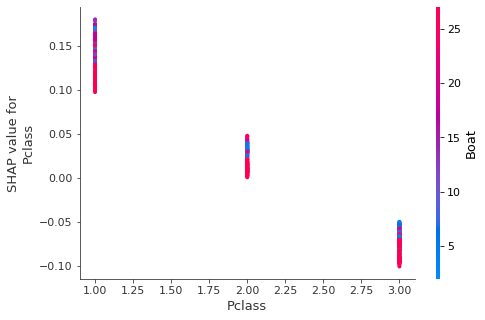

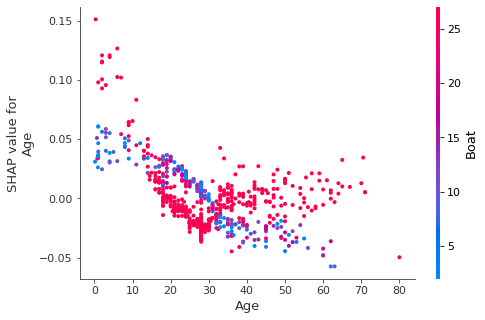

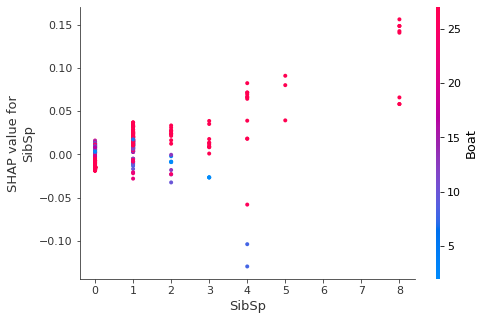

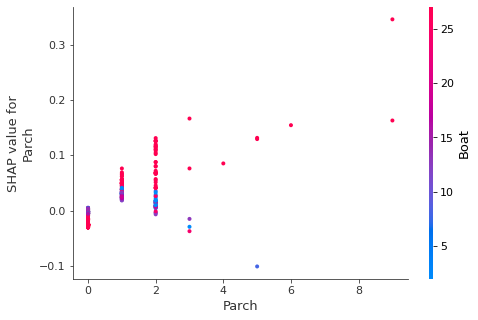

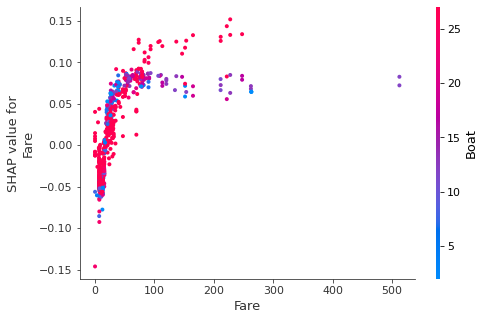

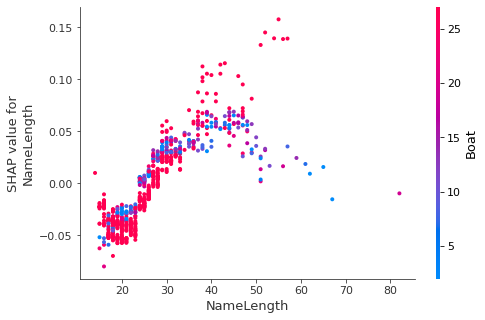

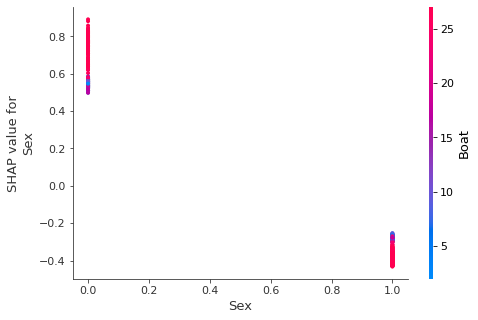

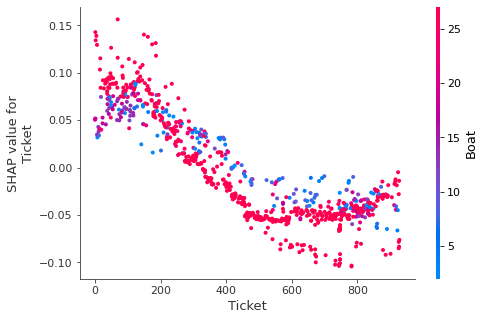

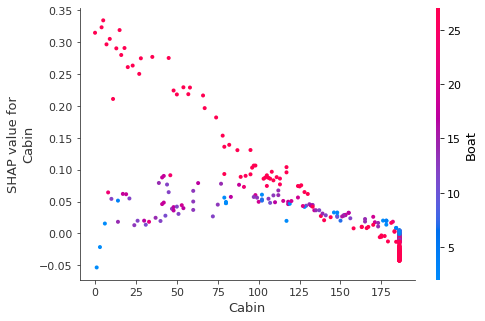

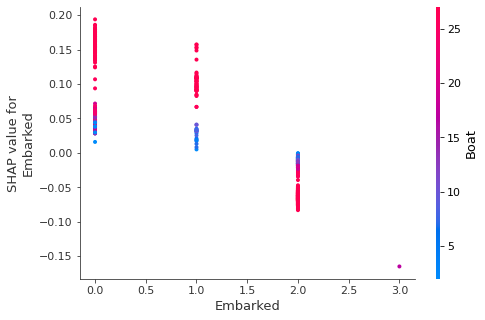

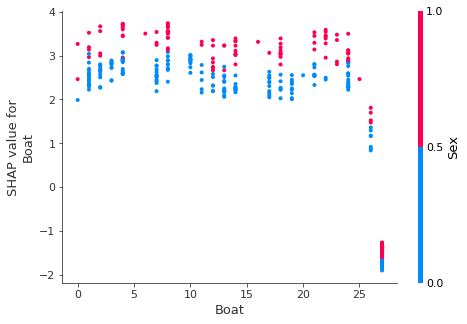

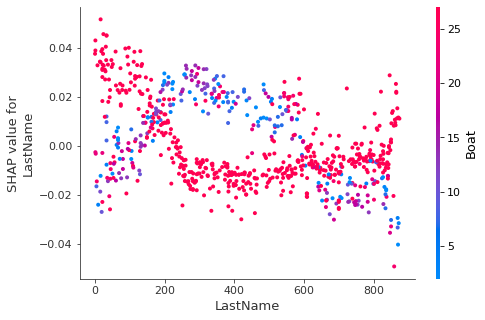

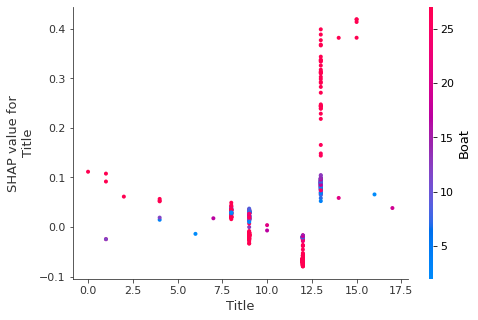

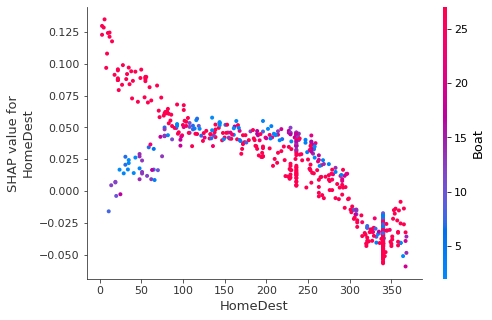

In [57]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)

### Cross-Validation

In [58]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

#### Model with Default Parameters

In [59]:
cvmodel = CatBoostClassifier(
    loss_function='Logloss',
    custom_loss=['Accuracy','Logloss','F1'],
    eval_metric='AUC', 
    iterations=100,
    learning_rate=0.03, 
    l2_leaf_reg=3.0, 
    #cat_features=categorical_features_indices,
    logging_level='Silent',
    early_stopping_rounds=None,
    model_shrink_mode=None,
    random_seed=theSeed)

In [60]:
y_pred = cross_val_predict(cvmodel, X_train, y_train, cv=5)

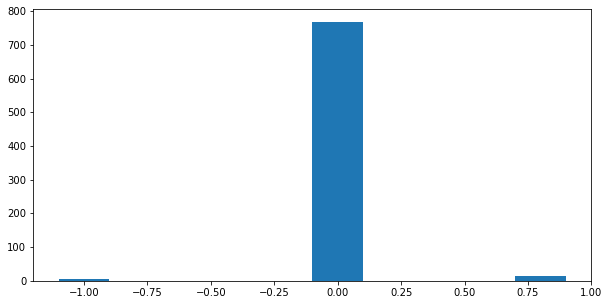

[0.00509554 0.         0.         0.         0.         0.97834395
 0.         0.         0.         0.01656051]


In [61]:
fig, ax = plt.subplots( figsize=(10,5) )

y_delta = y_train.to_numpy() - y_pred
n, bins, patches = ax.hist(y_delta, density=False, histtype='bar', rwidth=2.5, align='left', stacked=False)
plt.show()
print( n/len(y_pred) )

In [62]:
scores = cross_val_score(cvmodel, X_train, y_train, scoring='accuracy', cv=5)
scores

array([0.97452229, 0.98089172, 0.97452229, 0.97452229, 0.98726115])

In [63]:
scores = cross_validate(cvmodel, X_train, y_train, scoring=['accuracy','roc_auc','f1'], cv=5)
scores

{'fit_time': array([0.15718603, 0.14041305, 0.10594726, 0.13645506, 0.1844418 ]),
 'score_time': array([0.00797606, 0.00537586, 0.00452089, 0.00915194, 0.00866604]),
 'test_accuracy': array([0.97452229, 0.98089172, 0.97452229, 0.97452229, 0.98726115]),
 'test_roc_auc': array([0.98920237, 0.99533034, 0.98685576, 0.99446558, 0.9996541 ]),
 'test_f1': array([0.96610169, 0.97391304, 0.96491228, 0.96551724, 0.98275862])}

### Probability Calibration

In [64]:
from sklearn.calibration import CalibratedClassifierCV

In [65]:
calibrated_model = CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv='prefit')

In [66]:
calibrated_fit = calibrated_model.fit(X_test, y_test)

In [67]:
calibrated_y_pred  = calibrated_fit.predict(X_test)
calibrated_y_score = calibrated_fit.predict_proba(X_test)

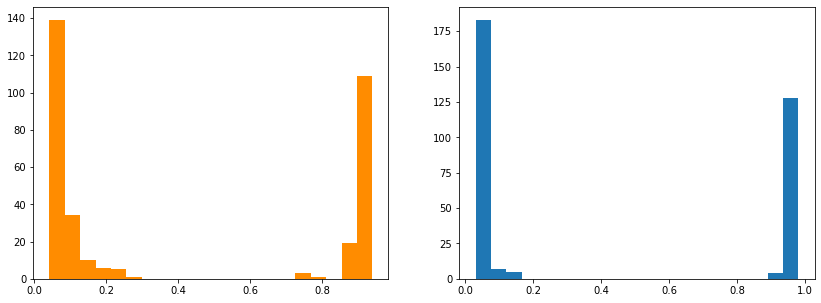

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14,5))
ax[0].hist(y_score[:,1], bins=21, color='darkorange')
ax[1].hist(calibrated_y_score[:,1], bins=21)
plt.show()